## Purpose

### Figure 3: Plot of edges colored by FC in US Gal/m
TimeWindows:
time 1: Weekdays 8-9 AM
time 2: Weekdays 5 - 6 PM
time 3: Weekdays 12 - 1 PM

Import Modules

In [20]:
import json
import warnings

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import numpy as np
import cPickle as pickle
import pandas as pd
import matplotlib.lines as mlines
import pysal as ps
import math
from TPtrip import *


Load the Streets network with Fuel Consumption as an attribute

In [22]:
streets =  pickle.load(open( "data/Riyadh_streets_FC_Figure3_alltimes.pkl", "rb" ) )


Make attribute $pos$ as a tuple of coordinates of each node

In [31]:
for i in streets.nodes():
    streets.node[i]['pos'] = (streets.node[i]['x'], streets.node[i]['y'])
    
pos=nx.get_node_attributes(streets,'pos')

Load flow values from Local Routing alpha = 0, P = [0.4,0.3,0.2,0.1]
Code for the Assignment used was reappropriated from 
https://github.com/PhilChodrow/riyadh_multiplex

In [6]:
riyad_edges_time1 = pd.read_csv('data/flow_byEdge_time1.csv', delimiter=',')
riyad_edges_time2 = pd.read_csv('data/flow_byEdge_time2.csv', delimiter=',')
riyad_edges_time3 = pd.read_csv('data/flow_byEdge_time3_midday.csv', delimiter=',')



Build a dict of edge to flow for each time
time 1 and time 2 are peak's so a factor of 1.5 is applied and divided by 3 for 7 - 10 AM and 4 for 4 - 8 PM 
time 3 is midday so a uniform distrinution of flow over the period is assumed . divided by 6 for 10 AM - 4 PM 
This is because flows from calles are an avg over a longer period than the TimeWindows used in this analysis


In [7]:
flow_time1_dict= {}
flow_time2_dict = {}
flow_time3_dict= {}
for i in range(len(riyad_edges_time1)):
    flow_time1_dict[riyad_edges_time1.iloc[i]['gid']]= riyad_edges_time1.iloc[i]['flow']*1.5/3
    
for i in range(len(riyad_edges_time2)):
    flow_time2_dict[riyad_edges_time2.iloc[i]['gid']]= riyad_edges_time2.iloc[i]['flow']*1.5/4
    
for i in range(len(riyad_edges_time3)):
    flow_time3_dict[riyad_edges_time3.iloc[i]['gid']]= riyad_edges_time3.iloc[i]['flow']/6

Cleaning Erros in flow time 2

In [8]:
FC_error = []  # save a tuple of e1,e2,gid,FC_avg
for e1,e2 in streets_time1.edges():
    if streets_time1[e1][e2]['FC_avg_time2'] > 100:
        FC_error.append((e1,e2,streets_time1[e1][e2]['gid'],streets_time1[e1][e2]['FC_avg_time2']))
        streets_time1[e1][e2]['FC_ByFlow_per_km_time2'] = 0.0
        streets_time1[e1][e2]['FC_ByFlow_time2'] = 0.0
        streets_time1[e1][e2]['FC_avg_time2'] = 0.0
        streets_time1[e1][e2]['FC_Estimate_time2'] = []
FC_error

[(333, 6369, 8177, 4158.4440814550508),
 (1753, 3848, 19638, 4155.1431390229527)]

Multiply the avg fuel rate by flow and save it as attribute 'FC_byflow' for each timeWindow


In [9]:
for e1,e2 in streets_time1.edges():
    try: flow1 = flow_time1_dict[streets_time1[e1][e2]['gid']] # flow in cars per hour
    except: flow1 = 0
    FC_rate1 = streets_time1[e1][e2]['FC_avg_time1'] # [US gallon/car]
    streets_time1[e1][e2]['FC_ByFlow_time1']= flow1*FC_rate1 # total FC gallon/hour
    dist = streets_time1[e1][e2]['len_km']*1000 # length of edge in meters
    streets_time1[e1][e2]['FC_ByFlow_per_km_time1']= (flow1*FC_rate1)/dist #rate of FC per meter per hour [gal/m.hr]
    streets_time1[e1][e2]['FE_ByFlow_lpm_time1'] =  (flow1*FC_rate1*3.785412)/dist # FE in [l/km.hr] 
    
    try: flow2 = flow_time2_dict[streets_time1[e1][e2]['gid']] # flow in cars per hour
    except: flow2 = 0
    FC_rate2 = streets_time1[e1][e2]['FC_avg_time2'] # [US gallon/car]
    streets_time1[e1][e2]['FC_ByFlow_time2']= flow2*FC_rate2 # total FC gallon/hour
    streets_time1[e1][e2]['FC_ByFlow_per_km_time2']= (flow2*FC_rate2)/dist #rate of FC per meter per hour [gal/m.hr]
    streets_time1[e1][e2]['FE_ByFlow_lpm_time2'] =  (flow2*FC_rate2*3.785412)/dist # FE in [l/km.hr] 
    
    try: flow3 = flow_time3_dict[streets_time1[e1][e2]['gid']] # flow in cars per hour
    except: flow3=0
    FC_rate3 = streets_time1[e1][e2]['FC_avg_time3_midday'] # [US gallon/car]
    streets_time1[e1][e2]['FC_ByFlow_time3']= flow3*FC_rate3 # total FC gallon/hour
    streets_time1[e1][e2]['FC_ByFlow_per_km_time3']= (flow3*FC_rate3)/dist #rate of FC per meter per hour [gal/m.hr]
    streets_time1[e1][e2]['FE_ByFlow_lpm_time3'] =  (flow3*FC_rate3*3.785412)/dist # FE in [l/km.hr] 

Calculating breaks for the color scheme. Quantiles of time 2 used for all time windows

In [10]:
FC_byEdge_lpm_list_alltimes= [streets_time1[e1][e2]['FE_ByFlow_lpm_time2'] for e1,e2 in streets_time1.edges() if not(math.isnan(streets_time1[e1][e2]['FE_ByFlow_lpm_time2']))and not streets_time1[e1][e2]['FE_ByFlow_lpm_time2']==0  ]
for e1,e2 in streets_time1.edges():
    if not(math.isnan(streets_time1[e1][e2]['FE_ByFlow_lpm_time1']))and not streets_time1[e1][e2]['FE_ByFlow_lpm_time1']==0 :
        FC_byEdge_lpm_list_alltimes.append(streets_time1[e1][e2]['FE_ByFlow_lpm_time1'])
    if not(math.isnan(streets_time1[e1][e2]['FE_ByFlow_lpm_time3']))and not streets_time1[e1][e2]['FE_ByFlow_lpm_time3']==0 :
        FC_byEdge_lpm_list_alltimes.append(streets_time1[e1][e2]['FE_ByFlow_lpm_time3'])

breaks_fc = ps.esda.mapclassify.Quantiles(FC_byEdge_lpm_list_alltimes, 5)
breaks_fc

                  Quantiles                   
 
 Lower              Upper                Count
           x[i] <=    0.167               4293
   0.167 < x[i] <=    0.553               4293
   0.553 < x[i] <=    1.278               4292
   1.278 < x[i] <=    2.862               4293
   2.862 < x[i] <= 3710.842               4293

Assign Colors to be consistent between all three plots
the breaks were obtained using FC_byflow_per_m_time2 using quintiles (equal number of observations in each class]
the nubers were rounded to the nearest .10 


In [11]:
time1 = 'FE_ByFlow_lpm_time1'
time2 ='FE_ByFlow_lpm_time2'
time3 = 'FE_ByFlow_lpm_time3'

#Based on time 2 only:
a = 3.603
b = 1.593
c = 0.657
d = 0.197

for e1,e2 in streets_time1.edges():
    if streets_time1[e1][e2][time1] > a: 
        streets_time1[e1][e2]['color1'] = 'r'
    elif streets_time1[e1][e2][time1] > b:
        streets_time1[e1][e2]['color1'] = "#ffa500" #orange
    elif streets_time1[e1][e2][time1] > c:
        streets_time1[e1][e2]['color1'] = 'y'
    elif streets_time1[e1][e2][time1] > d:
        streets_time1[e1][e2]['color1'] = '#32CD32' #Lime green
    elif (0 < streets_time1[e1][e2][time1]< d):
        streets_time1[e1][e2]['color1'] = "#006400" # Dark green
    else: 
        streets_time1[e1][e2]['color1'] = '0.92' # light grey for 0 values
                                   
    if streets_time1[e1][e2][time2] > a: 
        streets_time1[e1][e2]['color2'] = 'r'
    elif streets_time1[e1][e2][time2] > b:
        streets_time1[e1][e2]['color2'] = "#ffa500" #orange
    elif streets_time1[e1][e2][time2] > c:
        streets_time1[e1][e2]['color2'] = 'y'
    elif streets_time1[e1][e2][time2] > d:
        streets_time1[e1][e2]['color2'] = '#32CD32' #Lime green
    elif 0 < streets_time1[e1][e2][time2] < d :
        streets_time1[e1][e2]['color2'] = '#006400' # Dark green
    else: 
        streets_time1[e1][e2]['color2'] = '0.92' # light grey for 0 values
    
    if streets_time1[e1][e2][time3] > a: 
        streets_time1[e1][e2]['color3'] = 'r'
    elif streets_time1[e1][e2][time3] > b:
        streets_time1[e1][e2]['color3'] = "#ffa500" #orange
    elif streets_time1[e1][e2][time3] > c:
        streets_time1[e1][e2]['color3'] = 'y'
    elif streets_time1[e1][e2][time3] > d:
        streets_time1[e1][e2]['color3'] = '#32CD32' #Lime green
    elif 0 < streets_time1[e1][e2][time3] < d :
        streets_time1[e1][e2]['color3'] = '#006400' # Dark green
    else:
        streets_time1[e1][e2]['color3'] = '0.92' # light grey for 0 values
                                   
                                   
color1 = [streets_time1[e1][e2]['color1'] for e1,e2 in streets_time1.edges()]
color2 = [streets_time1[e1][e2]['color2'] for e1,e2 in streets_time1.edges()]
color3 = [streets_time1[e1][e2]['color3'] for e1,e2 in streets_time1.edges()]



In [12]:
def get_axis_limits(ax, scale=.9):
    return ax.get_xlim()[1]*scale, ax.get_ylim()[1]*scale

Plot all choropleth maps on the same plot: using alternate coloring based on all fuel timewindows 

/usr/local/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:124: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/usr/local/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:520: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/usr/local/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:524: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  for c in edge_color]):
/usr/local/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:136: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/usr/local/lib/pyth

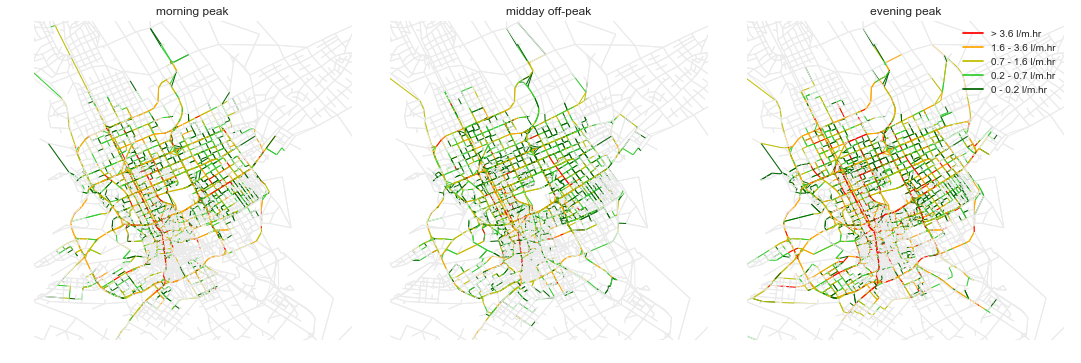

In [32]:
plt.close()

edges = streets_time1.edges()
fig, ax = plt.subplots(1,3, figsize =(15,5)) # one row, 3 columns
plt.tight_layout()
# on the far left, time1 (AM) FC 
nx.draw(streets_time1, pos, edges = edges, edge_color=color1 , width=1, node_size=0, arrows=False,ax =ax[0] )
ax[0].set_xlim([46.5,47.0])
ax[0].set_ylim([24.5,25.0])
ax[0].set_title('morning peak')
# on the far right, time2 (PM) FC 
nx.draw(streets_time1, pos, edges = edges, edge_color=color2 , width=1, node_size=0, arrows=False,ax =ax[2] )
ax[2].set_xlim([46.5,47.0])
ax[2].set_ylim([24.5,25.0])
ax[2].set_title('evening peak')
# in the center, time3 (MD) FC 
nx.draw(streets_time1, pos, edges = edges, edge_color=color3 , width=1, node_size=0, arrows=False,ax =ax[1] )
ax[1].set_xlim([46.5,47.0])
ax[1].set_ylim([24.5,25.0])
ax[1].set_title('midday off-peak')

ax[0].annotate('A', xy=get_axis_limits(ax[0]))
ax[1].annotate('B', xy=get_axis_limits(ax[1]))
ax[2].annotate('C', xy=get_axis_limits(ax[2]))
red_line = mlines.Line2D([], [], color='r', label='> %.1f l/m.hr' % (a))
orange_line = mlines.Line2D([], [], color="#ffa500", label='%.1f - %.1f l/m.hr' % (b, a))
yellow_line = mlines.Line2D([], [], color='y', label='%.1f - %.1f l/m.hr' % (c, b))
limeGr_line = mlines.Line2D([], [], color='#32CD32', label='%.1f - %.1f l/m.hr' % (d, c))
darkGr_line = mlines.Line2D([], [], color='#006400', label='0 - %.1f l/m.hr'% (d))
plt.legend(handles=[red_line, orange_line, yellow_line, limeGr_line, darkGr_line],loc = 'upper right')



plt.show()
# plt.savefig('Figure3_final3_SIunits_thicker_newflow.eps', bbox_inches = 'tight', dpi=300)